# Tweets Sentiment Analysis

### Steps
1. Textual Data Cleaning
2. Feature Engineering (Tfidf Vectorization)
3. Load the model from disk
4. Predict the sentiment of tweets

In [1]:
import pandas as pd

In [2]:
marriott_tweets = pd.read_csv('/Users/cynding/Desktop/Brandeis 2021 Fall/BUS 256A - Marketing Analytics/final project/marriott_tweets.csv')
review = pd.read_csv('/Users/cynding/Desktop/Brandeis 2021 Fall/BUS 256A - Marketing Analytics/final project/marriott_hotel_reviews.csv')
review['Review']=review['Review'].astype(str)

#### 1. Textual Data Cleaning

In [3]:
# return the wordnet object value corresponding to the POS tag
from nltk.corpus import wordnet
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

'''
Part-Of-Speech (POS) tagging: assign a tag to every word to define 
if it corresponds to a noun, a verb etc. using the WordNet lexical database
'''

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
def clean_text(text):
    # lower text
    text = text.lower()
    #
    text = text.replace("n't"," not")
    text = text.replace("i'm","i am")
    text = text.replace("i'd","i would")
    text = text.replace("i've","i have")
    text = text.replace("we're","we are")
    text = text.replace("'ll"," will")
    text = text.replace("that's","that is")
    
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text: transform every word into their root form 
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

In [4]:
review['Review'] = review['Review'].apply(lambda x: clean_text(x))
marriott_tweets['Text'] = marriott_tweets['Text'].apply(lambda x: clean_text(x))

#### 2. Feature Engineering - TFIDF Vectorization

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df = 5)

tfidf_result = tfidf.fit_transform(review['Review'].astype('U')).toarray()
tfidf_df = pd.DataFrame(tfidf_result,columns=tfidf.get_feature_names_out())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]

tfidf_df.index = review.index
review = pd.concat([review,tfidf_df],axis=1)

In [6]:
# For tiwtter text

tfidf_result = tfidf.transform(marriott_tweets['Text'].astype('U')).toarray()
tfidf_df_tweets = pd.DataFrame(tfidf_result,columns=tfidf.get_feature_names_out())
tfidf_df_tweets.columns = ["word_" + str(x) for x in tfidf_df_tweets.columns]

tfidf_df_tweets.index = marriott_tweets.index
marriott_tweets = pd.concat([marriott_tweets,tfidf_df_tweets],axis=1)

#### 3. Load the model from disk

In [7]:
# load the model from disk

import _pickle as pickle
filename = '/Users/cynding/Desktop/Brandeis 2021 Fall/BUS 256A - Marketing Analytics/final project/ml_model.sav'
rf = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)

#### 4. Predict the sentiment of tweets

In [8]:
features = [c for c in tfidf_df.columns]
X_twitter = marriott_tweets[features]
y_twitter_pred = rf.predict(X_twitter)

marriott_tweets = pd.concat([marriott_tweets, pd.Series(y_twitter_pred)], axis=1)
marriott_tweets = marriott_tweets.rename(columns={0: 'Predicted Score'})

In [20]:
marriott_tweets[['User','Time','Text','Predicted Score']].head()

,User,Time,Text,Predicted Score
0,MBonvoyAssist,2022-03-09 01:34:32,greiwejessica hi jessica usually point refund immediately would like look please dm provide marriott bonvoy member number email address associate account recently post past stay hotel name date stay,5.0
1,BruceCashbaugh,2022-03-09 01:32:57,mbonvoyassist rare time i’m marriott rumor beach restaurants true throughout san juan beach area true marriott resort casino,1.0
2,lawbreakerlegal,2022-03-09 01:32:46,tedcruz speaking year’s populist conference ritz cancun btw jw marriott’s better… sayin,1.0
3,ghs158,2022-03-09 01:32:44,accor\namerisourcebergen\narconic\nbridgestone tire\nbunge\ncargill\ncaterpillar\nciti\ncoty\ndeere\nfast retailing/uniqlo\nferragamo\nherbalife\nhilton\nhoneywell\nhyatt\nbridgestone tires\nchesnot\nintercontinental hotels\nkellogg\nkimberly-clark\nkraft heinz\nmarriott\nmars\nmohawk industry,1.0
4,TYee65965384,2022-03-09 01:32:36,tweetskoor haven’t year recall marriott property nice walk local restaurant nearby palm beach hotel stay rio inclusive nice bed uncomfortable pool property quite nice,5.0


In [9]:
marriott_tweets['Predicted Score'].value_counts()

1.0    83
5.0    29
4.0    22
3.0     6
2.0     4
Name: Predicted Score, dtype: int64

In [10]:
pd.set_option('display.max_colwidth', -1)

/var/folders/dl/l3zy8j197jn9h7zpll2v7q9w0000gn/T/ipykernel_10013/3652881321.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [24]:
marriott_tweets[marriott_tweets['Predicted Score']==1][['Text','Predicted Score']].sample(n=10)

,Text,Predicted Score
36,new try crab amp plank rustic artisan butcher middle hedge maze near marriott southkensington https://t.co/hnjcufmojk,1.0
80,marriott yeah yeah understand marriott prefers support genocide innocent people ukraine russian military aggression,1.0
42,mommoek marriottbonvoy marriott marriottintl courtyardhotels residenceinn marriottvacclub mbonvoyassist they’ve go silent message ceo zero response cancel night booking,1.0
142,click link bio see currently open facilitiesmgmt job like housekeep associate public space madison marriott middleton wi housekeepingassociate,1.0
135,andersostlund hiltonhotels marriott still allow book russian property,1.0
6,think wanna make parallel marriott rouge marriott put wall scared time harper genuine confident rouge kindhearted patient jeanie sassy hot temper,1.0
74,inspired real event theporterseries follow ensemble character hustle dream cross border pursue ambition fight liberation railway cross north america theporter,1.0
87,thanks marriott membersgetit rewardspoints findyourroute mrpoints,1.0
89,apparently follow company get memo stop business russia:\npapa johns\ncaterpillar\nnestle\nmarriott\nwhirlpool\nphillip morris\nkraft\nkelloggs\nmars\nafter death destruction persist make buck,1.0
70,rhino_records donnyhathawaylp start steve marriott ronnie lane thepoacher,1.0


In [17]:
marriott_tweets[marriott_tweets['Predicted Score']==5][['Text','Predicted Score']].sample(n=5)

,Text,Predicted Score
81,love experience marriott membersgetit rewardspoints findyourroute mrpoints,5.0
100,ipl team hotels:\n\ncsk trident nariman point.\nrcb taj land end.\nmi trident bkc.\nkkr itc grand central.\ndc taj palace.\nrr grand hyatt.\ngt jw marriot.\nlsg taj vivanta.\nsrh itc maratha.\npbks renaissance.\n\n jw marriott/conard hotel pune,5.0
59,altrinchamfc it’s joy commentate performance like every player alty squad superb goal game mkosylo first sensational finish pas game ball isaac_marriott delicious weight amp brianjamesflynn purr commentary ⚽️🎙,5.0
141,hill\nyale researcher release run list company still operate russia include nestle hilton hotel marriott hotel papa john's pizza kraft-heinz among others,5.0
60,love experience marriott membersgetit rewardspoints findyourroute mrpoints,5.0


(-1.1039482814586845,
 1.1001880158997213,
 -1.1232909631463632,
 1.1110129954640744)

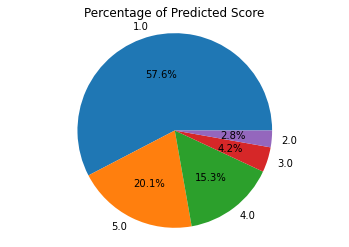

In [23]:
import matplotlib.pyplot as plt

a = marriott_tweets['Predicted Score'].value_counts(normalize=True)
# return the relative frequencies of the unique values
plt.pie(a.values,labels = a.index,autopct='%1.1f%%')
plt.title('Percentage of Predicted Score')
plt.axis('equal')

When we looked at the statistical summary of the predicted score, we can sense that the prediction is not very ideal as the average predicted score is 4.94 with only 4 predictions that is not a 5. 
This is align with the unbalanced structure of the training dataset (more than 90% of the records with the score 5) and the different wordings in the context of official website and twitter.